<h3>Rebuild ENEM's answers<br></h3>

The enem's math test consists of 45 single choice questions with alternatives ranging from A to E. In this scenario the last five answers have been removed from the test dataset, so you will rebuild them from the final average result - creating a model to predict the marked down answers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from src.send_answer import send_answer
from src.models.markov import Markov
from src.models.score import score, naive_approach

pd.set_option('display.max_columns', 100)

Considering the available options to choose from (A to E) and including the possibility to leave the question blank (*) the student last 5 answers would have a 1/7776 probability in a uniform distribution.<br><br> 

In [2]:
# input data
train = pd.read_csv('../../data/processed/train3.csv').set_index('NU_INSCRICAO')
validation = pd.read_csv('../../data/processed/validation3.csv').set_index('NU_INSCRICAO')
test = pd.read_csv('../../data/processed/test3.csv').set_index('NU_INSCRICAO')

In [3]:
# number of previous answers to take in account to predict the next values
order = 3

# number of answers to predict per row
streak = 5

# target to predict
target = 'TX_RESPOSTAS_MT'

# fields to segment the dataset
id = ['CO_PROVA_MT', 'group']

### Strategy
The strategy to overcome the dataset diversity consists on segmenting data in subsets in which the likelihood of similar answers gets increased. Not only using the `math test codes` but utilizing `k_means` to analyze the previously filled answers to better define the subsets.

Additionally, a validation set will be taken from the train set to identify potential overfitting

In [4]:
# merging the dataframes
prev_answers = pd.concat([train.loc[:, [target,id[0]]], validation.loc[:, [target,id[0]]], test.loc[:, [target,id[0]]]])

# select the threshold to limit the number of answers in the training set
until = max(prev_answers.TX_RESPOSTAS_MT.str.len())-streak

# concatenate with the trimmed and featured answers as well as with the corresponding math test codes
prev_answers = pd.concat([
    pd.DataFrame(list(map(lambda x: list(x), prev_answers.TX_RESPOSTAS_MT.str[:until]))).set_index(prev_answers.index),
    prev_answers.CO_PROVA_MT
    ], 
    axis=1
)

# create empty collumn to store the clusters' ids
prev_answers['group'] = 0

# since some of the math test codes present to few values, kmeans will one be used for those that possess more than 200 values
print("Number of samples per math test code:\n{}".format(
    [len(prev_answers.loc[prev_answers.CO_PROVA_MT == i]) for i in prev_answers.CO_PROVA_MT.unique()])
)

# add the threshold to avoid over-fragmenting the dataset
codes = [i for i in prev_answers.CO_PROVA_MT.unique() if len(prev_answers.loc[prev_answers.CO_PROVA_MT == i]) > 200]

Number of samples per math test code:
[3326, 3085, 3161, 3128, 87, 79, 80, 69]


In [5]:
# create label encoder for the answers and fit in the dataset
label_encod = LabelEncoder()
label_encod.fit(['A','B','C','D','E','*']);
prev_answers.iloc[:,:-2] = prev_answers.iloc[:,:-2].apply(label_encod.transform)

**How to define the number of clusters?**  <a href="https://www.coursera.org/lecture/machine-learning/choosing-the-number-of-clusters-Ks0E9">Elbow method</a>

To define the ideal number of clusters in the `k_means` algorithm is to iterate through possible number of clusters and identify the moment where the slope prominently changes, selecting this point as the `k` number of clusters

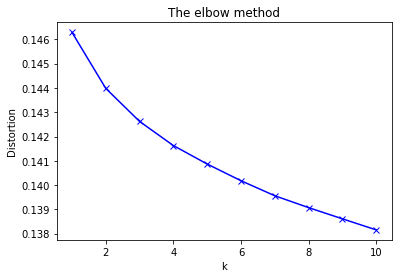

In [6]:
# k means determine k
distortions = []

# take the first code as an example
code = codes[0]

# select the corresponding values
X = prev_answers.loc[prev_answers.CO_PROVA_MT == code].iloc[:,:-2].values

#range the k-number of clusters from 1 to 10
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_jobs=-1).fit(X)
    distortions.append(np.sqrt(kmeanModel.inertia_)/ X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The elbow method')
plt.show()

However, in this case, as in many other real case scenarios, the slope changes much more progressively than abruptly, invalidating the elbow method. Therefore the number of clusters is based on an acceptable and arbitrary amount of samples to train the Markov chains

In [7]:
k_clusters = 10

for code in codes:
    X = prev_answers.loc[prev_answers.CO_PROVA_MT == code].iloc[:,:-2].values
    kmeanModel = KMeans(n_clusters=k_clusters, init='random')
    kmeanModel.fit(X)
    prev_answers.loc[prev_answers.CO_PROVA_MT == code,'group'] = kmeanModel.labels_

train.loc[:,'group'] = prev_answers.loc[train.index, 'group']
test.loc[:, 'group'] = prev_answers.loc[test.index, 'group']
validation.loc[:,'group'] = prev_answers.loc[validation.index, 'group']

<h3>Estimate</h3><br>
The underlying idea of the following function is to predict written answer for its k_cluster as well as for its corresponding test using a Markov Chain.<br>

*Reference materials:*
<ol>
    <li><a href="https://www.youtube.com/watch?v=eGFJ8vugIWA">Coding Train - Markov Chains</a></li>
    <li><a href="http://setosa.io/ev/markov-chains/">Markov Chains Visually Explained</a></li>
</ol>

In [8]:
model = Markov(order, streak, target, id)
model.train_chain(train, save=False)

predict = {
    'train': lambda df, id, target: model.predict(df[target][-(order+streak):-streak], tuple(df.loc[id].values)),
    'test': lambda df, id, target: model.predict(df[target][-order:], tuple(df.loc[id].values))
}

train['PREDICTION'] = train.apply(predict['train'], id=id, target=target, axis=1)
validation['PREDICTION'] = validation.apply(predict['train'], id=id, target=target, axis=1)
test['PREDICTION'] = test.apply(predict['test'], id=id, target=target, axis=1)

### Results

In [9]:
print('Training set accuracy: %.2f' % (score(train.TX_RESPOSTAS_MT.str[-streak:], train.PREDICTION)*100))
print('Validation set accuracy: %.2f' % (score(validation.TX_RESPOSTAS_MT.str[-streak:], validation.PREDICTION)*100))
print('Naive approach accuracy: %.2f' % (naive_approach(validation)*100))

Training set accuracy: 58.61
Validation set accuracy: 24.14
Naive approach accuracy: 19.80


Again, it's plausible to infer, by observing the train and validation results, that the Markov chain is very conditioned to the trained results, thus implying in a overfit

**Send answers**

In [10]:
answer = test.copy().loc[:,['PREDICTION']]
answer = answer.rename(index=str, columns={"PREDICTION": "TX_RESPOSTAS_MT"})
#send_answer(answer.reset_index(), 3)